In [4]:
map_scale = 2
p = 0.8
!optuna-dashboard sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db

Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [03/Mar/2024 22:17:46] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [03/Mar/2024 22:17:46] "GET /api/studies HTTP/1.1" 200 270
127.0.0.1 - - [03/Mar/2024 22:17:48] "GET /api/meta HTTP/1.1" 200 32
/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [03/Mar/2024 22:17:54] "GET /api/studies/2?after=0 HTTP/1.1" 200 464005
127.0.0.1 - - [03/Mar/2024 22:17:55] "GET /api/studies/2/param_importances HTTP/1.1" 200 482
127.0.0.1 - - [03/Mar/2024 22:17:59] "GET /api/studies/2/param_importances HTTP/1.1" 200 482
/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/study/_study_summary.py:115: FutureWarning: `system

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optuna

In [6]:
def plot_accuracy_evolution(trial, label=""):
    def smooth(x, w=0.01):
        filter = jnp.ones(int(1 + w * len(x)))
        smoothed = jnp.convolve(jnp.array(x), filter / filter.sum(), mode="full")
        return smoothed[: len(x)]

    mean = smooth(trial.user_attrs["accuracy_evol_mean"])
    std = smooth(trial.user_attrs["accuracy_evol_std"])
    upper_bound = smooth(trial.user_attrs["accuracy_evol_max"])
    lower_bound = smooth(trial.user_attrs["accuracy_evol_min"])
    plt.plot(mean, label=label)
    color = plt.gca().lines[-1].get_color()
    # plt.plot(smooth(mean+std), color=color, linestyle="--")
    # plt.plot(smooth(mean-std), color=color, linestyle="--")
    plt.fill_between(range(len(mean)), smooth(upper_bound), smooth(lower_bound), alpha=0.3, color=color)

    stages_duration = [
        trial.user_attrs["cycle_train_iter"] * trial.params[f"train_cycles_{i}"]
        for i in cell_scales[:-1]
    ]
    for stage_duration in jnp.cumsum(jnp.array(stages_duration)):
        plt.axvline(stage_duration, color="k", linestyle="--")

n_trials 47
n_trials 74


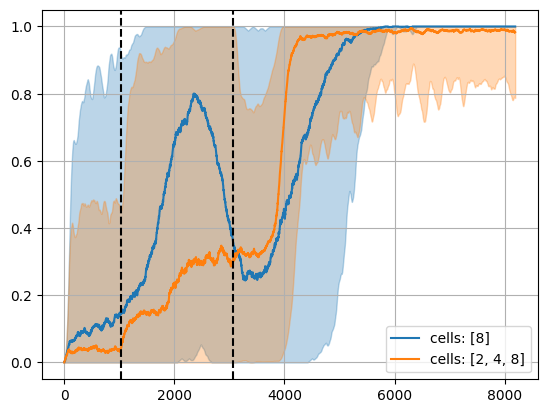

In [7]:
map_scale = 3
p = 0.8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db"
for cell_scales in [(map_scale,), tuple(range(1, map_scale + 1))]:
    study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}", storage=storage_path)
    print("n_trials", len(study.trials))
    plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]}")
plt.grid()
plt.legend()